In [35]:
learn = pd.read_parquet("../notebooks/data/learn.parquet")
test  = pd.read_parquet("../notebooks/data/test.parquet")
learn.head()

,IDpol,Exposure,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Area,Density,Region,ClaimNb,AreaGLM,VehPowerGLM,VehAgeGLM,DrivAgeGLM,BonusMalusGLM,DensityGLM,fold
0,1,0.10,5,0,55,50,B12,Regular,D,1217,Rhone-Alpes,0,4,5,1,6,50,7.104144,1
1,3,0.77,5,0,55,50,B12,Regular,D,1217,Rhone-Alpes,0,4,5,1,6,50,7.104144,4
2,5,0.75,6,2,52,50,B12,Diesel,B,54,Picardie,0,2,6,2,6,50,3.988984,4
3,10,0.09,7,0,46,50,B12,Diesel,B,76,Aquitaine,0,2,7,1,5,50,4.330733,3
4,11,0.84,7,0,46,50,B12,Diesel,B,76,Aquitaine,0,2,7,1,5,50,4.330733,3


In [38]:
# Zelle 0 — Laden & Grundchecks
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt, statsmodels.api as sm

FIGDIR = "../figures"

# 1) Policy-Frames laden
learn = pd.read_parquet("../notebooks/data/learn.parquet")
test  = pd.read_parquet("../notebooks/data/test.parquet")

# 2) Frequenzrate laden und an test ausrichten (per IDpol falls vorhanden)
freq_df = pd.read_parquet("../notebooks/data/test_freq_rate.parquet")
if {"IDpol", "freq_rate"}.issubset(freq_df.columns):
    assert test["IDpol"].is_unique, "Duplikate in test['IDpol']"
    freq_pred_test = test["IDpol"].map(freq_df.set_index("IDpol")["freq_rate"]).to_numpy()
else:
    # Reihenfolge-Annahme nur nutzen, wenn du sie in 03_* bewusst so gespeichert hast
    freq_pred_test = freq_df.squeeze().to_numpy()

# 3) Severity (claim-level) laden + säubern
sev = pd.read_parquet("../data/work/freMTPL2sev_clean.parquet")
sev["ClaimAmount"] = pd.to_numeric(sev["ClaimAmount"], errors="coerce")
sev = sev.loc[sev["ClaimAmount"].gt(0) & np.isfinite(sev["ClaimAmount"]), ["IDpol","ClaimAmount"]]

# 4) Grundchecks
assert "IDpol" in learn and "IDpol" in test and "IDpol" in sev, "IDpol fehlt in learn/test/sev"
assert len(freq_pred_test) == len(test), "Längenmismatch: freq_pred_test vs. test"
assert np.isfinite(freq_pred_test).all(), "freq_pred_test enthält NaN/Inf"

print("learn/test shapes:", learn.shape, test.shape)
print("freq_pred_test:", freq_pred_test.shape, "sev:", sev.shape)


learn/test shapes: (542741, 19) (135272, 19)
freq_pred_test: (135272,) sev: (26639, 2)


# Frequenzrate laden – wenn IDpol-Spalte vorhanden: per Join ausrichten
freq_df = pd.read_parquet("../notebooks/data/test_freq_rate.parquet")
if "IDpol" in freq_df.columns and "freq_rate" in freq_df.columns:
    assert test["IDpol"].is_unique, "Duplikate in test['IDpol']"
    freq_pred_test = test["IDpol"].map(freq_df.set_index("IDpol")["freq_rate"]).to_numpy()
else:
    # Reihenfolge = Test-Reihenfolge 
    freq_pred_test = freq_df.squeeze().to_numpy()

# Severity sanity check
sev = pd.read_parquet("../data/work/freMTPL2sev_clean.parquet")
sev["ClaimAmount"] = pd.to_numeric(sev["ClaimAmount"], errors="coerce")
sev = sev.loc[sev["ClaimAmount"].gt(0) & np.isfinite(sev["ClaimAmount"]), ["IDpol", "ClaimAmount"]]

# Basiskontrollen
assert np.isfinite(freq_pred_test).all(), "freq_pred_test enthält NaN/Inf"
print("learn/test shapes:", learn.shape, test.shape)
print("freq_pred_test:", freq_pred_test.shape, "sev:", sev.shape)


In [39]:
learn.head()

,IDpol,Exposure,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Area,Density,Region,ClaimNb,AreaGLM,VehPowerGLM,VehAgeGLM,DrivAgeGLM,BonusMalusGLM,DensityGLM,fold
0,1,0.10,5,0,55,50,B12,Regular,D,1217,Rhone-Alpes,0,4,5,1,6,50,7.104144,1
1,3,0.77,5,0,55,50,B12,Regular,D,1217,Rhone-Alpes,0,4,5,1,6,50,7.104144,4
2,5,0.75,6,2,52,50,B12,Diesel,B,54,Picardie,0,2,6,2,6,50,3.988984,4
3,10,0.09,7,0,46,50,B12,Diesel,B,76,Aquitaine,0,2,7,1,5,50,4.330733,3
4,11,0.84,7,0,46,50,B12,Diesel,B,76,Aquitaine,0,2,7,1,5,50,4.330733,3


In [40]:
# nutze ALLE verfügbaren Policy-Features außer IDpol/Exposure.
feature_cols = [c for c in learn.columns if c not in ["IDpol", "Exposure"]]


# Policy-Features für beide Splits zusammenführen
pol_features = pd.concat(
    [learn[["IDpol"] + feature_cols], test[["IDpol"] + feature_cols]],
    axis=0, ignore_index=True
).drop_duplicates("IDpol")

# Severity (claim-level) mit Policy-Features verheiraten (m:1 Join)
sev_feat = sev.merge(pol_features, on="IDpol", how="left", validate="m:1")
missing = sev_feat[feature_cols].isna().any(axis=1).mean()
print(f"Anteil Zeilen mit fehlenden Features: {missing:.2%}")

Anteil Zeilen mit fehlenden Features: 0.73%


In [41]:
# 1) Diagnose: welche IDs fehlen?
sev_ids = set(sev["IDpol"])
pol_ids = set(pol_features["IDpol"])
missing_ids = sev_ids - pol_ids
print(f"Unmatched claim IDs: {len(missing_ids)} ({len(missing_ids)/len(sev_ids):.2%})")

# 2) Entschiedene Behandlung: <1% -> droppen (sauberste Variante)
before = len(sev_feat)
sev_feat = sev_feat.dropna(subset=feature_cols).copy()
after = len(sev_feat)
print(f"Dropped {before - after} claim rows with missing features "
      f"({(before-after)/before:.2%}). Remaining: {after}")

Unmatched claim IDs: 6 (0.02%)
Dropped 195 claim rows with missing features (0.73%). Remaining: 26444


In [42]:
# Designmatrix aus sev_feat (ohne Kappung nötig)
cat_cols = [c for c in feature_cols if sev_feat[c].dtype.name in ("object","category")]
num_cols = [c for c in feature_cols if c not in cat_cols]
X_cat = pd.get_dummies(sev_feat[cat_cols], drop_first=True, dtype=float) if cat_cols else pd.DataFrame(index=sev_feat.index)
X_num = sev_feat[num_cols].apply(pd.to_numeric, errors="coerce") if num_cols else pd.DataFrame(index=sev_feat.index)
X_sev = pd.concat([X_num, X_cat], axis=1).replace([np.inf,-np.inf], np.nan).fillna(0.0)
X_sev = X_sev.loc[:, X_sev.var(numeric_only=True) > 0].astype(float)
X_sev_sm = sm.add_constant(X_sev, has_constant="add")

y_log = np.log1p(sev_feat["ClaimAmount"].astype(float).to_numpy())
model_sev = sm.OLS(y_log, X_sev_sm).fit()
sev_pred_claim = np.expm1(model_sev.predict(X_sev_sm))  # zurück auf €-Skala
print(model_sev.summary().tables[1])


                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
const                                  6.1131      0.109     55.967      0.000       5.899       6.327
VehPower                              -0.0079      0.011     -0.720      0.472      -0.029       0.014
VehAge                                -0.0043      0.002     -1.722      0.085      -0.009       0.001
DrivAge                                0.0032      0.002      1.775      0.076      -0.000       0.007
BonusMalus                            -0.0112      0.007     -1.558      0.119      -0.025       0.003
Density                             -2.86e-06   5.42e-06     -0.528      0.598   -1.35e-05    7.76e-06
ClaimNb                                0.0348      0.019      1.875      0.061      -0.002       0.071
AreaGLM                                0.0808      0.022      3.620      

E[X] (Test) mean: 947.68
E[N] (Test) mean: 0.03885
PP mean: 36.98


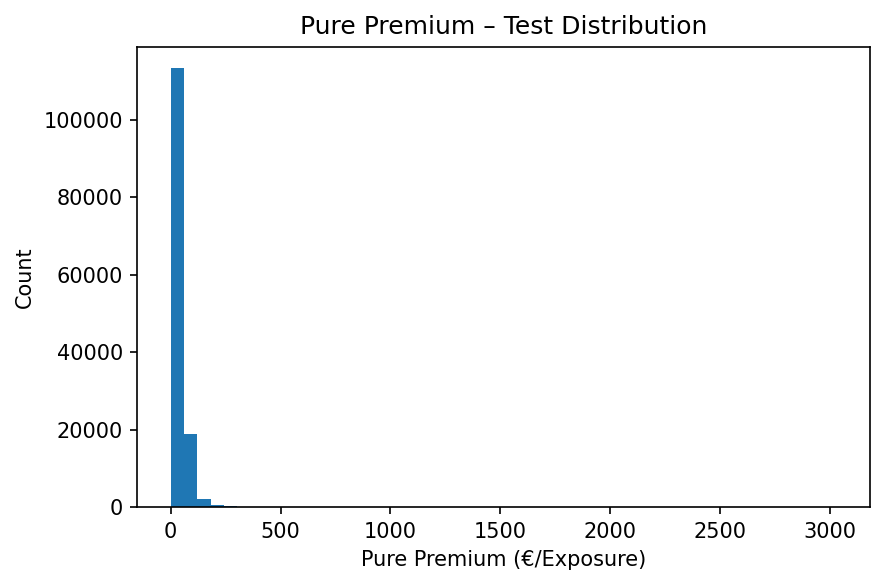

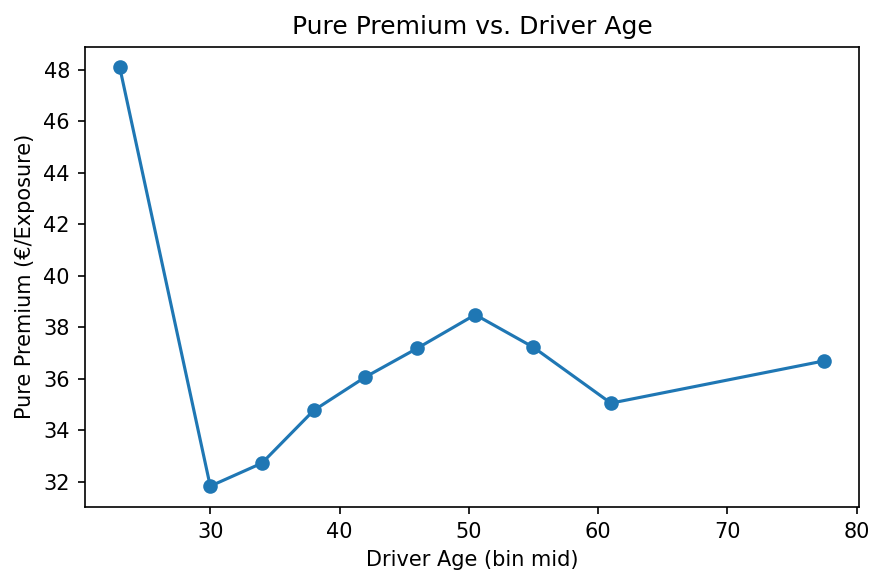

In [43]:
# Erwartete Schwere je Police = Mittel der claim-level Predictions je IDpol
sev_pred_df = sev_feat[["IDpol"]].copy()
sev_pred_df["pred_claim_amount"] = sev_pred_claim
sev_policy_mean = sev_pred_df.groupby("IDpol", as_index=True)["pred_claim_amount"].mean()

# Auf TEST-Policen mappen; fehlende Policen (ohne Schaden) mit globalem Mittel füllen
global_avg_sev = float(sev_policy_mean.mean())
E_X_test = test["IDpol"].map(sev_policy_mean).fillna(global_avg_sev).astype(float).to_numpy()

# Pure Premium = Frequenzrate × erwartete Severity (€/Exposure)
PP_test = freq_pred_test * E_X_test

test = test.copy()
test["E_X"] = E_X_test
test["PP"]  = PP_test

print("E[X] (Test) mean:", test["E_X"].mean().round(2))
print("E[N] (Test) mean:", freq_pred_test.mean().round(5))
print("PP mean:", test["PP"].mean().round(2))

# Plots (Distribution + optional vs. Alter)
plt.figure(figsize=(6,4), dpi=150)
plt.hist(test["PP"], bins=50)
plt.xlabel("Pure Premium (€/Exposure)"); plt.ylabel("Count")
plt.title("Pure Premium – Test Distribution")
plt.tight_layout(); plt.savefig(os.path.join(FIGDIR, "pure_premium_hist.png"), dpi=150, bbox_inches="tight"); plt.show()

cand = next((c for c in ["DrivAge","DrivAgeGLM","DriverAge","DrivAgeBinMid"] if c in test.columns), None)
if cand:
    s = test[cand]
    if pd.api.types.is_numeric_dtype(s):
        q = pd.qcut(s, 10, duplicates="drop")
        g = test.groupby(q, observed=True)["PP"].mean().reset_index()
        mids = g[cand].apply(lambda iv: 0.5*(iv.left + iv.right))
        plt.figure(figsize=(6,4), dpi=150)
        plt.plot(mids, g["PP"], marker="o")
        plt.xlabel("Driver Age (bin mid)"); plt.ylabel("Pure Premium (€/Exposure)")
        plt.title("Pure Premium vs. Driver Age")
        plt.tight_layout(); plt.savefig(os.path.join(FIGDIR, "pure_premium_drivage.png"), dpi=150, bbox_inches="tight"); plt.show()


In [44]:
pearson_chi2 = sum(model_sev.resid_pearson**2)
dispersion = pearson_chi2 / model_sev.df_resid
print(f"Dispersion: {dispersion:.2f}")


Dispersion: 1.00


In [45]:
# Kategoriale vs. numerische bestimmen 
cat_cols = [c for c in feature_cols if sev_feat[c].dtype.name in ("object","category")]
num_cols = [c for c in feature_cols if c not in cat_cols]

# Dummy-Matrix 
X_cat = pd.get_dummies(sev_feat[cat_cols], drop_first=True) if cat_cols else pd.DataFrame(index=sev_feat.index)
X_num = sev_feat[num_cols].apply(pd.to_numeric, errors="coerce") if num_cols else pd.DataFrame(index=sev_feat.index)

X_sev = pd.concat([X_num, X_cat], axis=1).fillna(0.0)
y_sev = sev_feat["ClaimAmount"].astype(float).to_numpy()

# Intercept
X_sev_sm = sm.add_constant(X_sev, has_constant="add")
print("Design:", X_sev_sm.shape, "Targets:", y_sev.shape)


Design: (26444, 56) Targets: (26444,)


In [46]:
# --- bool -> float konvertieren ---
bool_cols = X_sev_sm.select_dtypes(bool).columns
if len(bool_cols):
    X_sev_sm[bool_cols] = X_sev_sm[bool_cols].astype(float)
    print(f"{len(bool_cols)} bool-Spalten in float konvertiert:", list(bool_cols))

44 bool-Spalten in float konvertiert: ['VehBrand_B10', 'VehBrand_B11', 'VehBrand_B12', 'VehBrand_B13', 'VehBrand_B14', 'VehBrand_B2', 'VehBrand_B3', 'VehBrand_B4', 'VehBrand_B5', 'VehBrand_B6', 'VehGas_Regular', 'Area_B', 'Area_C', 'Area_D', 'Area_E', 'Area_F', 'Region_Alsace', 'Region_Aquitaine', 'Region_Auvergne', 'Region_Basse-Normandie', 'Region_Bourgogne', 'Region_Bretagne', 'Region_Champagne-Ardenne', 'Region_Corse', 'Region_Franche-Comte', 'Region_Haute-Normandie', 'Region_Ile-de-France', 'Region_Languedoc-Roussillon', 'Region_Limousin', 'Region_Midi-Pyrenees', 'Region_Nord-Pas-de-Calais', 'Region_Pays-de-la-Loire', 'Region_Picardie', 'Region_Poitou-Charentes', "Region_Provence-Alpes-Cotes-D'Azur", 'Region_Rhone-Alpes', 'VehAgeGLM_1', 'VehAgeGLM_3', 'DrivAgeGLM_1', 'DrivAgeGLM_2', 'DrivAgeGLM_3', 'DrivAgeGLM_4', 'DrivAgeGLM_6', 'DrivAgeGLM_7']


In [47]:
gamma = sm.families.Gamma(sm.families.links.log())
# Claim-level
model_sev = sm.OLS(np.log1p(y_sev), X_sev_sm).fit()
print(model_sev.summary().tables[1])

                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
const                                  6.1131      0.109     55.967      0.000       5.899       6.327
VehPower                              -0.0079      0.011     -0.720      0.472      -0.029       0.014
VehAge                                -0.0043      0.002     -1.722      0.085      -0.009       0.001
DrivAge                                0.0032      0.002      1.775      0.076      -0.000       0.007
BonusMalus                            -0.0112      0.007     -1.558      0.119      -0.025       0.003
Density                             -2.86e-06   5.42e-06     -0.528      0.598   -1.35e-05    7.76e-06
ClaimNb                                0.0348      0.019      1.875      0.061      -0.002       0.071
AreaGLM                                0.0808      0.022      3.620      

/home/steve/code/freMTPL2-pricing/.venv/lib/python3.12/site-packages/statsmodels/genmod/families/links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(


In [48]:
pearson_chi2 = sum(model_sev.resid_pearson**2)
dispersion = pearson_chi2 / model_sev.df_resid
print(f"Dispersion: {dispersion:.2f}")


Dispersion: 1.00


In [49]:
# Erwartete Claim-Schwere je Schaden (claim-level)
sev_pred_claim = model_sev.predict(X_sev_sm)

# Erwartete Schwere je Policy = Mittel der claim-level Predictions je IDpol
sev_pred_df = sev_feat[["IDpol"]].copy()
sev_pred_df["pred_claim_amount"] = sev_pred_claim
sev_policy_mean = sev_pred_df.groupby("IDpol")["pred_claim_amount"].mean()

# Auf TEST-Policen mappen; fehlende (Policen ohne Schaden im Datensatz) mit globalem Mittel füllen
global_avg_sev = sev_policy_mean.mean()
sev_mean_test = test[["IDpol"]].assign(
    E_X = test["IDpol"].map(sev_policy_mean).fillna(global_avg_sev).astype(float)
)

# Frequenzrate (λ̂ pro Exposure) × erwartete Severity
pure_premium = freq_pred_test * sev_mean_test["E_X"].to_numpy()

test = test.copy()
test["E_X"] = sev_mean_test["E_X"].to_numpy()
test["PP"]  = pure_premium

print("E[X] (Test) mean:", test["E_X"].mean().round(2), "— PP mean:", test["PP"].mean().round(2))


E[X] (Test) mean: 6.84 — PP mean: 0.27


In [50]:
import re, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_pp_vs_feature(test_df, candidates=("DrivAge","DrivAgeGLM","DriverAge","DrivAgeBinMid"),
                       figdir="../figures"):
    os.makedirs(figdir, exist_ok=True)
    # Feature wählen
    feat = next((c for c in candidates if c in test_df.columns), None)
    if feat is None:
        print("Kein geeignetes Feature gefunden – PP-vs-Feature-Plot wird übersprungen.")
        return

    s = test_df[feat]
    # Fall A: numerisch → Deciles + Linienplot
    if pd.api.types.is_numeric_dtype(s):
        q = pd.qcut(s, 10, duplicates="drop")
        g = test_df.groupby(q, observed=True)["PP"].mean().reset_index()
        mids = g[feat].apply(lambda iv: 0.5*(iv.left + iv.right))
        plt.figure(figsize=(6,4), dpi=150)
        plt.plot(mids, g["PP"], marker="o")
        plt.xlabel(f"{feat} (bin mid)")
        plt.ylabel("Pure Premium (€/Exposure)")
        plt.title(f"Pure Premium vs. {feat}")
        plt.tight_layout()
        plt.savefig(os.path.join(figdir, f"pure_premium_vs_{feat.lower()}.png"),
                    dpi=150, bbox_inches="tight")
        plt.show()
        return

    # Fall B: kategorial → Mittel je Kategorie; wenn Intervalle, nach Mitte sortieren
    def _mid(v):
        if pd.api.types.is_interval(v): return 0.5*(v.left+v.right)
        if isinstance(v,str):
            m = re.match(r"[\(\[]\s*([-+]?\d+\.?\d*)\s*,\s*([-+]?\d+\.?\d*)\s*[\)\]]", v)
            if m: return (float(m.group(1))+float(m.group(2)))/2
        return np.nan

    g = test_df.groupby(s.astype("category"), observed=True)["PP"].mean().reset_index()
    mids = g[feat].apply(_mid)
    if mids.notna().all():
        order = np.argsort(mids.values)
        x, y = mids.values[order], g["PP"].values[order]
        plt.figure(figsize=(6,4), dpi=150)
        plt.plot(x, y, marker="o")
        plt.xlabel(f"{feat} (bin mid)")
        plt.ylabel("Pure Premium (€/Exposure)")
        plt.title(f"Pure Premium vs. {feat} (categorical)")
        plt.tight_layout()
        plt.savefig(os.path.join(figdir, f"pure_premium_vs_{feat.lower()}.png"),
                    dpi=150, bbox_inches="tight")
        plt.show()
    else:
        g2 = g.sort_values("PP")
        plt.figure(figsize=(7,4), dpi=150)
        plt.bar(g2[feat].astype(str), g2["PP"])
        plt.xticks(rotation=45, ha="right")
        plt.ylabel("Pure Premium (€/Exposure)")
        plt.title(f"Pure Premium by {feat}")
        plt.tight_layout()
        plt.savefig(os.path.join(figdir, f"pure_premium_by_{feat.lower()}.png"),
                    dpi=150, bbox_inches="tight")
        plt.show()


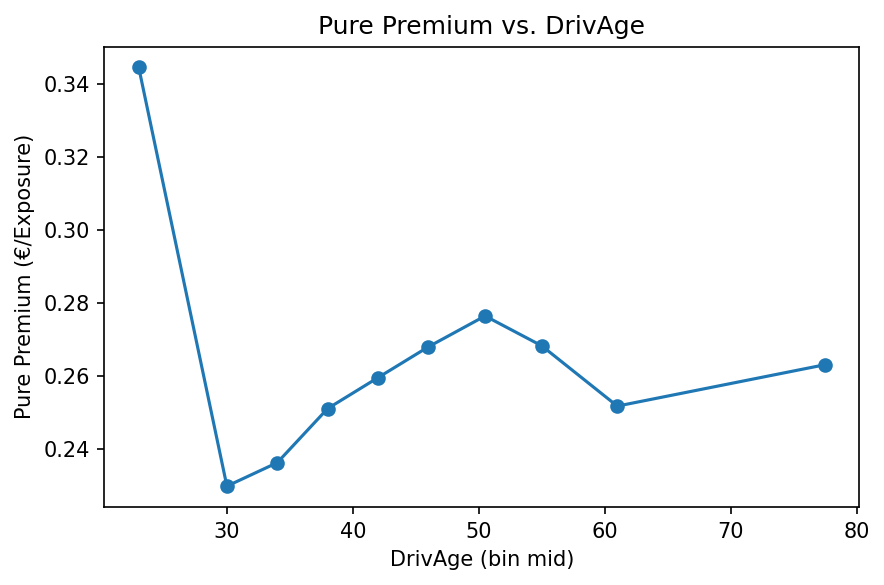

In [51]:
plot_pp_vs_feature(test)

In [17]:
# tatsächlicher Schaden pro Exposure im Test (falls ClaimAmount & Exposure vorhanden)
# Wenn du die echten Summen im Test nicht hast: diesen Block weglassen.
if {"ClaimNb","Exposure"}.issubset(test.columns):
    # grobe Erwartungscheck: PP_mean ≈ (Total Claims * avg severity) / Total Exposure
    print("Exposure sum:", test["Exposure"].sum().round(0))
print("E[X] mean:", test["E_X"].mean().round(2),
      "E[N] mean:", freq_pred_test.mean().round(5),
      "PP mean:", test["PP"].mean().round(2))


E[X] mean: 6.85 E[N] mean: 0.03885 PP mean: 0.27


In [18]:
print("E[X] (Test) mean:", test["E_X"].mean().round(2))
print("E[N] (Test) mean:", freq_pred_test.mean().round(5))
print("PP mean:", test["PP"].mean().round(2))


E[X] (Test) mean: 6.85
E[N] (Test) mean: 0.03885
PP mean: 0.27
